### Prudhviraj TIrumanisetti
EE 258 ID:011489881

## Part 2: Clustering (45 points)
Unsupervised data mining methods are fairly diverse. At one extreme, there are the pure statistical summarization techniques that are the mainstay of exploratory data analysis, somewhere in between are data transformations like principal components analysis, which have a deeper mathematical underpinning but a fairly mechanical formulation, and at the other extreme you have unsupervised models that make strong assumptions about the data distribution. Clustering methods fall into that latter category: they make an assumption about instance similarity given attributes and use this modeling assumption to provide an interpretable division of a dataset. 

The strong modeling assumptions made by clustering algorithms have varying benefits and drawbacks. In some cases, the modeling assumption of a clustering algorithm adheres to our intuitions about the data. For example, we may use a Gaussian mixture model for normally distributed data, and get extremely useful results. In other cases, the modeling assumptions are clearly incorrect, but these assumptions may provide a simpler formulation that pragmatically works quite well for a dataset. As an example, in mixture modeling for text corpora (like the news example in class), we make the assumption that documents are built by randomly drawing words independently of each other (but dependent on the cluster) -- this is not how journalists write news articles, but it turns out this simplifying assumption allows fairly powerful models. In the worst case, the modeling assumptions conflict with the underlying data generating process and impede our ability to understand the data. For example, in class we discussed how distance functions do not always work as we expect, and two people who both like food and music may have the same distance as two people who both like food, music, hiking, biking, camping, and rock climbing, even though we expect that the first pair will have far less to talk about than the second pair.

In this part of the assignment, we'll use the scikit-learn implementations of [clustering](http://scikit-learn.org/stable/modules/clustering.html) in the clustering and mixture modules. We'll explore four different clustering methods ([k-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [Gaussian mixture models](http://scikit-learn.org/stable/modules/mixture.html#gmm), and [Agglomerative clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)) and try to better understand the modeling assumptions each makes. 

In [6]:
## Preliminaries

#Show plots in the notebook
%matplotlib inline

from sklearn import datasets, preprocessing, cross_validation, feature_extraction
from sklearn import linear_model, svm, metrics, ensemble, neighbors, mixture, gg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib2
import random
import math

# Helper functions
def folds_to_split(data,targets,train,test):
    data_tr = pd.DataFrame(data).iloc[train]
    data_te = pd.DataFrame(data).iloc[test]
    labels_tr = pd.DataFrame(targets).iloc[train]
    labels_te = pd.DataFrame(targets).iloc[test]
    return [data_tr, data_te, labels_tr, labels_te]

def computeLabelPercentage(data, axis=0):
    return data.groupby(by=axis).size().apply(lambda x: x/data.count())

## Question 1: Implementing the basic k-Means algorithm (15 points)
Let's work through the writing the code for a basic k-means implementation. Assume you have data this is either a numpy ndarray or pandas DataFrame.
1. Write a function `sample_centroids` that takes as parameters k and your data, then picks k (distinct) random data points as centroids. (The function `random.sample` may be helpful)
2. Write a function `find_closest_centroid`  that takes as parameters a list of centroids and your data, then computes the distance of each instance to each of k centroids, and returns the minimum centroid for each instance. Use euclidean distance in your implementation.
3. Write a function `update_centroid` that takes as a parameter a dataset containing the instances mapped to a particular centroid and returns the new centroid
4. Put these together in a function `kmeans` that samples centroids and loops over the steps of finding the closest centroid for each instance and updating the centroids until no centroid assignments change.
5. Put it all together: generate some sample data using `make_blobs` and confirm that your k-Means implementation works. At each iteration, plot the data points and cluster assignments. (See the [scikit-learn clustering comparison](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) example if you need some help with figuring out the plotting)

In [7]:
# 1. sample_centroids

def sample_centroids(k, data):
    data_clean = data
    indexes = random.sample(data.index, k)
    centroids = data.iloc[indexes]
    return [centroids, indexes]


In [8]:
# 2. find_closest_centroid
def find_closest_centroid(centroids, data):
    data_values = data.values
    inst_cent_map = []
    
    for row in range(0, len(data_values)):
        centroid_distances = []
    
        for centroid in range(0, len(centroids)):
            distance = 0
            cent = centroids[centroid]
            
            for col in range(0, len(data_values[0])):
                x = cent[col]
                y = data_values[row][col]
                distance += (x - y)**2    

            distance = math.sqrt(distance)
            centroid_distances.append(distance)            
        closest_centroid = centroid_distances.index(min(centroid_distances))
        inst_cent_map.append([data_values[row], centroids[closest_centroid], closest_centroid])
    return inst_cent_map


In [9]:
# 3. update_centroid

def update_centroid(instances_centroid_map, k_means):
    new_centroids = []
    for i in range(0, k_means): 
        same_centroid_instances = []
        
        added_initial_centroid = 0
        for instance in range(0, len(instances_centroid_map)):
            instance_features = instances_centroid_map[instance][0]
            centroid_points = instances_centroid_map[instance][1]
            centroid_group = instances_centroid_map[instance][2]
            
            if (centroid_group == i):
                if (added_initial_centroid != 1):
                    same_centroid_instances.append(centroid_points)
                    added_initial_centroid = 1
                same_centroid_instances.append(instance_features)
                
        new_centroid = []
        if (len(same_centroid_instances) > 0):
            for feature in range(0, len(same_centroid_instances[0])):
                feature_total = 0
                total_instances = len(same_centroid_instances)

                for inst in range(0, total_instances):
                    instance = same_centroid_instances[inst]    
                    feature_total += instance[feature]

                new_centroid.append(round(feature_total / total_instances, 4))

            new_centroids.append([new_centroid, total_instances])
    return new_centroids

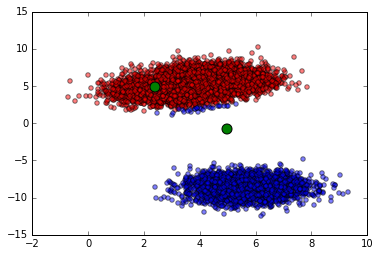

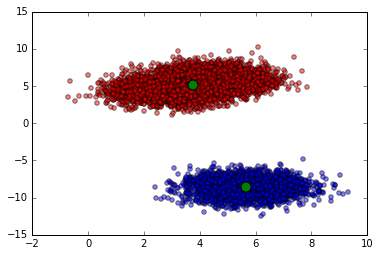

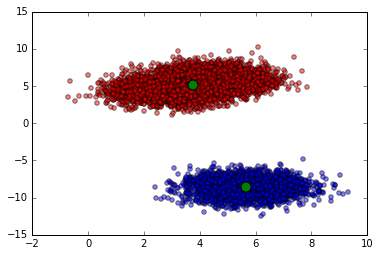

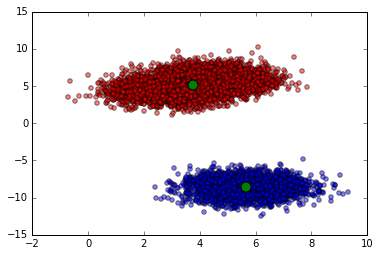

In [10]:
# 4. Generating data and putting it all together 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


[data, targets] = datasets.make_blobs(n_samples=10000, n_features=2,
                    random_state=20160217)

data = pd.DataFrame(data)
targets = pd.DataFrame(targets)


def k_means():
    # Sample centroids
    data_clean = data
    k_means = 2
    [centroids, indexes] = sample_centroids(k_means, data)
    
    # init total_instances
    total_instances = []
    for i in range(0, k_means):
        total_instances.append(1)
    
    data_clean.drop(data_clean.index[indexes], inplace=True)
    centroids = centroids.values
    
    centroid_updated = 1;
    while (centroid_updated == 1):

        centroid_updated = 0
        
        instances_centroids_map = find_closest_centroid(centroids, data_clean)
        
        old_centroids = centroids
        centroids_info = update_centroid(instances_centroids_map, k_means)
        centroids = []
        
        new_total_instances = []
        for i in range(0, len(centroids_info)):
            centroids.append(centroids_info[i][0])
            new_total_instances.append(centroids_info[i][1])
        
        if total_instances == new_total_instances:
            centroid_updated = 0
            centroids = old_centroids
        else:
            centroid_updated = 1
            total_instances = new_total_instances
        
        x_points_red = []
        y_points_red = []
                    
        x_points_blue = []
        y_points_blue = []
        
        x_centroids = []
        y_centroids = []
        
        instances_centroids_map = find_closest_centroid(centroids, data_clean)
        for inst in range(0, len(instances_centroids_map)):
            instance = instances_centroids_map[inst][0]
            
            if (centroids[0] == instances_centroids_map[inst][1]):
                x_points_red.append(instance[0])
                y_points_red.append(instance[1])
            else:
                x_points_blue.append(instance[0])
                y_points_blue.append(instance[1])
            
        for cent in range(0, len(centroids)):
            x_centroids.append(centroids[cent][0])
            y_centroids.append(centroids[cent][1])

        plt.scatter(x_points_red, y_points_red, c='r', alpha=0.5)
        plt.scatter(x_points_blue, y_points_blue, c='b', alpha=0.5)
        
        plt.scatter(x_centroids, y_centroids, c='g', s=100)
        plt.show()
        
    
    return [centroids, data]


[centroids, data] = k_means()

## Flower Arrangements with Python
In this assignment, we'll look at three different clustering algorithms. The first is k-Means -- you're pretty familiar with that algorithm since you just implemented it.  Not that your code isn't beautiful, but we'll be using the [scikit-learn K-Means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to make sure we have consistent results

Next, is hierarchical clustering, also known as agglomerative clustering. Hierarchical clustering starts out with each instance as its own cluster, then merges the two closest clusters, thus reducing the number of clusters by 1. This merging continues until only the desired number of clusters remain. The main implementation question in hierarchical clustering is how to compute the distance between two clusters of points. The [sklearn implementation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) offers a few options. 
* average: compute all pairwise distances between the two clusters, and then take the average of these distances
* complete (also known as maximum) linkage: compute all pairwise distances and use the largest distance 
* Ward: compute the change in cluster variance after all possible cluster merges and choose the merge that results in the smallest variance increase

Finally, there are [Gaussian Mixture Models](http://scikit-learn.org/stable/modules/mixture.html#gmm). These models assume that the attribute values in each dimension follow a Gaussian (or normal) distribution. One nice feature of this assumption is that the Gaussian models can account for differing attribute variances. For example, if an "income" attribute has a very large range, and a "years of education" has a small range, the fit variance for the former attribute will be large, and for the latter attribute will be small. Of course, you already know how to achieve a somewhat similar result in other algorithms, right?

Let's look at three different clustering algorithms on the Iris dataset. In the plot below, the columns correspond to the three clustering algorithms and ground truth - the flower species. The rows correspond to a combination of two of the four attributes (petal length, petal width, sepal length, sepal width), of which there are six (4 choose 2). Given the four attributes, you'll have to think high-dimensionally to really get a sense of the clusterings. You can see that all of the clustering algorithms roughly correspond to the true "clusters" that are based on the the flower species. However, each behaves slightly differently. Hierarchical clustering with complete linkage will prefer small, compact clusters. You can see in the last row of the figure how the red cluster for hierarchical clustering remains small, while the other algorithms have more mixing. In that last row, you can also notice how the Gaussian mixture model estimates a higher variance for the attributes in the blue cluster (which have outliers in the top right), resulting in more cluster mixing. By comparison, the same cluster in k-Means has its center pulled towards the extreme which results in a smaller cluster focused on the outliers.


                0           1           2           3
count  150.000000  150.000000  150.000000  150.000000
mean     5.843333    3.054000    3.758667    1.198667
std      0.828066    0.433594    1.764420    0.763161
min      4.300000    2.000000    1.000000    0.100000
25%      5.100000    2.800000    1.600000    0.300000
50%      5.800000    3.000000    4.350000    1.300000
75%      6.400000    3.300000    5.100000    1.800000
max      7.900000    4.400000    6.900000    2.500000


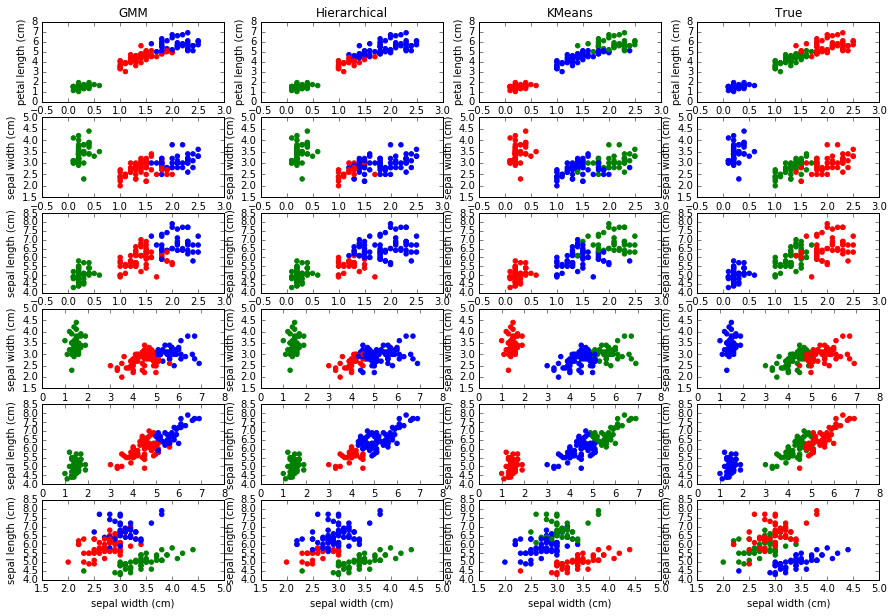

In [11]:
iris = datasets.load_iris()
print pd.DataFrame(iris.data).describe()
clusterers = {
    'KMeans':cluster.KMeans(n_clusters=3, init='random', random_state=20160217),
    'Hierarchical':cluster.AgglomerativeClustering(n_clusters=3, linkage='complete'),
    'GMM':mixture.GMM(n_components=3, random_state=20160217),
    }

clusterings = {'True':iris.target}

for clusterer in clusterers.iterkeys():
    clusterings[clusterer]=clusterers[clusterer].fit_predict(iris.data)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
plt.figure(figsize=(15,10))
pnum=1
for x in range(3,0,-1):
    for y in range(x-1, -1, -1):
        for clusterer in sorted(clusterings.keys()):
            plt.subplot(6,4,pnum)
            if pnum < 5: plt.title(clusterer) 
            plt.xlabel(iris.feature_names[x])
            plt.ylabel(iris.feature_names[y])
            plt.scatter(iris.data[:,x], iris.data[:,y], color=colors[clusterings[clusterer]].tolist())
            pnum+=1
        

In [12]:
# Load Heart Data
heart_data = urllib2.urlopen("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
heart = pd.read_csv(heart_data, quotechar='"', skipinitialspace=True, names=['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBloodSugar', 'RestingECG', 'MaxHeartRate', 'ExerciseInducedAngina', 'STExerciseDepression', 'STExercisePeakSlope', 'FlouroscopyVessels', 'Thalassemia', 'HeartDisease'], na_values="?")
heart=heart.dropna()
heart_attrs = heart.ix[:,:-1]
heart_labels = heart.ix[:,-1]
heart_processed = pd.DataFrame(preprocessing.StandardScaler().fit_transform(heart_attrs))
heart_labels_values = heart_labels.values

## Question 2: Clustering Heart Disease (15 points)
In this exercise, you'll be clustering the heart disease data we've seen in a couple of assignments already. I've loaded and processed the data for you. You'll be using the three clusterers from the example above (KMeans, Hierarchical, GMM), using the same `random_state` settings and initialization as in the example. Cluster the processed heart data using five clusters and the three clustering algorithms. 
   * Compute the cluster sizes. What do you notice about the cluster sizes for each algorithm?
   * Compute the mean value of the HeartDisease column (heart_labels) for each cluster. How well do the clusters correspond to differing heart disease conditions?
   * Write a function that `wss` computes the within-cluster sum of square errors (MSE of a cluster) and a function `bss` to compute the between-cluster sum of square errors (see the lecture slides!), and report both metrics for each of the clustering methods.
   * For each of the clusterings (15 total), choose one attribute that has a different distribution than the overall data, and discuss how the distribution differs for that attribute.
   * Make a figure showing boxplots of each attribute in each clustering, as well as a figure with a boxplot of all the data. (The figure should have three rows [one for each clustering algorithm] and six columns [one for all the data, five for each of the clusterings], and each boxplot will have twelve attributes. 


<h1> Answers 2. </h1>
<p> 1. Cluster sizes <br>
Clustering Method: Hierarchical <br>
Cluster: 0 size: 131<br>
Cluster: 1 size: 129<br>
Cluster: 2 size: 13<br>
Cluster: 3 size: 1<br>
Cluster: 4 size: 23<br><br>
Clustering Method: KMeans<br>
Cluster: 0 size: 39<br>
Cluster: 1 size: 65<br>
Cluster: 2 size: 62<br>
Cluster: 3 size: 46<br>
Cluster: 4 size: 85<br><br>
Clustering Method: GMM<br>
Cluster: 0 size: 60<br>
Cluster: 1 size: 89<br>
Cluster: 2 size: 78<br>
Cluster: 3 size: 43<br>
Cluster: 4 size: 27<br></p>

<p> 2. Cluster means <br>

Clustering Method: Hierarchical<br>
Cluster: 0 mean: 0.4275<br>
Cluster: 1 mean: 1.1705<br>
Cluster: 2 mean: 2.5385<br>
Cluster: 3 mean: 0.0<br>
Cluster: 4 mean: 1.7826<br><br>
Clustering Method: KMeans<br>
Cluster: 0 mean: 1.0<br>
Cluster: 1 mean: 1.9846<br>
Cluster: 2 mean: 0.2097<br>
Cluster: 3 mean: 1.6522<br>
Cluster: 4 mean: 0.2824<br><br>
Clustering Method: GMM<br>
Cluster: 0 mean: 2.2667<br>
Cluster: 1 mean: 0.1124<br>
Cluster: 2 mean: 1.0385<br>
Cluster: 3 mean: 1.093<br>
Cluster: 4 mean: 0.2593<br>


<p> 3. WSS <br>
Hierarchical: 3151.18560967<br>
KMeans: 2605.73353663<br>
GMM: 2770.36699076<br>
<br>
BSS <br>
Hierarchical: 709.81439033<br>
KMeans: 1255.26646337<br>
GMM: 1090.63300924<br>


</p>
<p> 4. One different attribute for each mode for each cluster. <br>
See bellow for boxplots for each. <br>
Hierarchical <br>
Cluster 0 - Attr 5 - all same values (-0.411450),  except one point (2.430427)<br>
Cluster 1- Attr 5 - all same values (-0.411450),  except one point (2.430427)<br>
Cluster 2 - Attr 5 - same values, no distribution -0.411450<br>
Cluster 3- Attr 5 - there’s only one point here<br>
Cluster 4 - Attr 5 - same values, no distribution 2.430427<br><br>

KMeans<br>
Cluster 0 - Attr 5 - same values, no distribution - 2.430427<br>
Cluster 1- Attr 5 - all same values (-0.411450),  except one point (2.430427)<br>
Cluster 2 - Attr 5 - same values, no distribution - -0.41145<br>
Cluster 3 - Attr 5 - same values, no distribution - -0.41145<br>
Cluster 4 - Attr 5 - same values, no distribution - -0.41145<br><br>

GMM<br>
Cluster 0 - Attr 2- same values, no distribution -  0.87388<br>
Cluster 1 - Attr 8 - all same values, no distribution - -0.696419<br>
Cluster 2 - Attr 5 - same values, no distribution - -0.41145<br>
Cluster 3 - Attr 5 - same values, no distribution - 2.430427<br>
Cluster 4 - Attr 5 - same values, no distribution - -0.41145<br>


In [13]:
# Part 1 Cluster Count
from sklearn import mixture, cluster

clusterers = {
    'KMeans':cluster.KMeans(n_clusters=5, init='random', random_state=20160217),
    'Hierarchical':cluster.AgglomerativeClustering(n_clusters=5, linkage='complete'),
    'GMM':mixture.GMM(n_components=5, random_state=20160217),
    }

clusterings = {'True':heart_labels}

for clusterer in clusterers.iterkeys():
    clusterings[clusterer]=clusterers[clusterer].fit_predict(heart_processed)
    

hieararchical_count = {}
kmeans_count = {}
gmm_count = {}

# Cluster sizes
for clusterer in clusterers.iterkeys():
    print "Clustering Method: " + clusterer
    for cluster in range(0, 5):
        bincount = np.bincount(clusterings[clusterer])
    for cluster in range(0, len(bincount)):
        print "Cluster: " + str(cluster) + " size: " + str(bincount[cluster])    
        if (clusterer == 'KMeans'):
            kmeans_count[str(cluster)] = bincount[cluster]
        elif clusterer == 'Hierarchical':
            hieararchical_count[str(cluster)] = bincount[cluster]
        else:
            gmm_count[str(cluster)] = bincount[cluster]


Clustering Method: Hierarchical
Cluster: 0 size: 131
Cluster: 1 size: 129
Cluster: 2 size: 13
Cluster: 3 size: 1
Cluster: 4 size: 23
Clustering Method: KMeans
Cluster: 0 size: 39
Cluster: 1 size: 65
Cluster: 2 size: 62
Cluster: 3 size: 46
Cluster: 4 size: 85
Clustering Method: GMM
Cluster: 0 size: 60
Cluster: 1 size: 89
Cluster: 2 size: 78
Cluster: 3 size: 43
Cluster: 4 size: 27


In [14]:
# Part 2 Cluster means
from sklearn import mixture, cluster

clusterers = {
    'KMeans':cluster.KMeans(n_clusters=5, init='random', random_state=20160217),
    'Hierarchical':cluster.AgglomerativeClustering(n_clusters=5, linkage='complete'),
    'GMM':mixture.GMM(n_components=5, random_state=20160217),
    }

clusterings = {'True':heart_labels}

for clusterer in clusterers.iterkeys():
    clusterings[clusterer]=clusterers[clusterer].fit_predict(heart_processed)

hieararchical_means = {}
kmeans_means = {}
gmm_means = {}

# Cluster sizes
for clusterer in clusterers.iterkeys():
    print "Clustering Method: " + clusterer
    for cluster in range(0, 5):
        cluster_mean = 0
        cluster_count = 0
        for i in range(0, len(clusterings[clusterer])):
            if (clusterings[clusterer][i] == cluster):
                cluster_mean += heart_labels_values[i]
                cluster_count +=1

        cluster_mean = round(float(cluster_mean / float(cluster_count)),4)
        if (clusterer == 'KMeans'):
            kmeans_means[str(cluster)] = cluster_mean
        elif clusterer == 'Hierarchical':
            hieararchical_means[str(cluster)] = cluster_mean
        else:
            gmm_means[str(cluster)] = cluster_mean
            
        print "Cluster: " + str(cluster) + " mean: " + str(cluster_mean)


Clustering Method: Hierarchical
Cluster: 0 mean: 0.4275
Cluster: 1 mean: 1.1705
Cluster: 2 mean: 2.5385
Cluster: 3 mean: 0.0
Cluster: 4 mean: 1.7826
Clustering Method: KMeans
Cluster: 0 mean: 1.0
Cluster: 1 mean: 1.9846
Cluster: 2 mean: 0.2097
Cluster: 3 mean: 1.6522
Cluster: 4 mean: 0.2824
Clustering Method: GMM
Cluster: 0 mean: 2.2667
Cluster: 1 mean: 0.1124
Cluster: 2 mean: 1.0385
Cluster: 3 mean: 1.093
Cluster: 4 mean: 0.2593


In [15]:
# Part 3 WSS
from sklearn import mixture, cluster
pd.set_option('display.height', 1500)
pd.set_option('display.max_rows', 1500)

clusterers = {
    'KMeans':cluster.KMeans(n_clusters=5, init='random', random_state=20160217),
    'Hierarchical':cluster.AgglomerativeClustering(n_clusters=5, linkage='complete'),
    'GMM':mixture.GMM(n_components=5, random_state=20160217),
    }

clusterings = {'True':heart_labels}

for clusterer in clusterers.iterkeys():
    clusterings[clusterer]=clusterers[clusterer].fit_predict(heart_processed)


def wss(kmeans):
    wss = 0
    # Iterate over each cluster
    for cluster in range(0, 5):
        cluster_instances = []
        # Iterate over each instance of the dataset
        for i in range(0, len(kmeans)):
            # If that dataset instance is in the right cluster
            if (kmeans[i] == cluster):
                cluster_instances.append(i)

        heart_cluster = heart_processed.iloc[cluster_instances]
        cols = heart_cluster.shape[1]
        
        for col in range(0, cols):
            feature_vals = heart_cluster[col].values
            attr_mean = 0
            for i in range(0, len(feature_vals)):
                attr_mean += feature_vals[i]
            
            attr_mean = float(attr_mean / float(len(feature_vals)))
            
            for i in range(0, len(feature_vals)):
                point = (feature_vals[i] - attr_mean)**2
                wss+= point
    return wss

for clusterer in clusterers.iterkeys():
    clusterings[clusterer]=clusterers[clusterer].fit_predict(heart_processed)


for clusterer in clusterers.iterkeys():
    print str(clusterer) + " WSS:"
    if clusterer == 'KMeans':
        print wss(clusterings[clusterer])
    elif clusterer == 'Hierarchical':
        print wss(clusterings[clusterer])
    else:
        print wss(clusterings[clusterer])

height has been deprecated.

Hierarchical WSS:
3151.18560967
KMeans WSS:
2605.73353663
GMM WSS:
2770.36699076


In [16]:
# Part 3 BSS
from sklearn import mixture, cluster

def bss(kmeans):
    bss = 0
    mean_of_means = 0
    
    mean_of_means = heart_processed.mean()
    for cluster in range(0, 5):
        cluster_instances = []
        # Iterate over each instance of the dataset
        for i in range(0, len(kmeans)):
            # If that dataset instance is in the right cluster
            if (kmeans[i] == cluster):
                cluster_instances.append(i)

        heart_cluster = heart_processed.iloc[cluster_instances]
        attrs_means = heart_cluster.mean()
        
        for i in range(0, len(attrs_means)):
            bss += len(cluster_instances) * (attrs_means[i] - mean_of_means[i])**2
        
    return bss

# print bss(hieararchical_means, hieararchical_count)
for clusterer in clusterers.iterkeys():
    print str(clusterer) + " BSS:"
    if clusterer == 'KMeans':
        print bss(clusterings[clusterer])
    elif clusterer == 'Hierarchical':
        print bss(clusterings[clusterer])
    else:
        print bss(clusterings[clusterer])

Hierarchical BSS:
709.81439033
KMeans BSS:
1255.26646337
GMM BSS:
1090.63300924


Hierarchical Cluster: 0
          0         1         2         3         4         5         6   \
3  -1.941680  0.691095 -0.164289 -0.095506  0.051047 -0.411450 -1.003419   
4  -1.498933 -1.446980 -1.202459 -0.095506 -0.835103 -0.411450  1.010199   
5   0.161372  0.691095 -1.202459 -0.659431 -0.218651 -0.411450 -1.003419   
10  0.272059  0.691095  0.873880  0.468418 -1.066272 -0.411450 -1.003419   
13 -1.166872  0.691095 -1.202459 -0.659431  0.301480 -0.411450 -1.003419   
14 -0.281376  0.691095 -0.164289  2.272976 -0.931424  2.430427 -1.003419   
15  0.272059  0.691095 -0.164289  1.032342 -1.528611 -0.411450 -1.003419   
16 -0.724124  0.691095 -1.202459 -1.223355 -0.353500 -0.411450 -1.003419   
17 -0.060002  0.691095  0.873880  0.468418 -0.160859 -0.411450 -1.003419   
19 -0.613437  0.691095 -1.202459 -0.095506  0.359273 -0.411450 -1.003419   

          7         8         9         10        11        12  
3   1.633010 -0.696419  2.099753  2.264145 -0.721976 -0.894220  
4   0.978

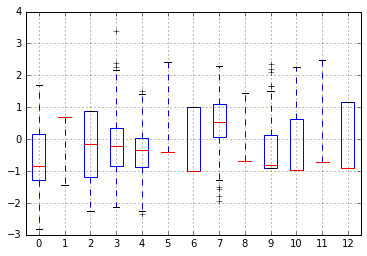

Hierarchical Cluster: 1
          0         1         2         3         4         5         6   \
1   1.378929  0.691095  0.873880  1.596266  0.744555 -0.411450  1.010199   
2   1.378929  0.691095  0.873880 -0.659431 -0.353500 -0.411450  1.010199   
7   0.272059 -1.446980  0.873880 -0.659431  2.054515 -0.411450 -1.003419   
8   0.936181  0.691095  0.873880 -0.095506  0.128103 -0.411450  1.010199   
11  0.161372 -1.446980 -1.202459  0.468418  0.898668 -0.411450  1.010199   
18 -0.724124 -1.446980 -0.164289 -0.095506  0.532650 -0.411450 -1.003419   
20  1.046868  0.691095 -2.240629 -1.223355 -0.700254 -0.411450  1.010199   
21  0.382746 -1.446980 -2.240629  1.032342  0.686763  2.430427  1.010199   
22  0.382746  0.691095 -1.202459 -0.659431  0.706027 -0.411450  1.010199   
23  0.382746  0.691095 -0.164289  0.017278 -0.449820 -0.411450  1.010199   

          7         8         9         10        11        12  
1  -1.816334  1.435916  0.381773  0.643781  2.478425 -0.894220  
2  -0.899

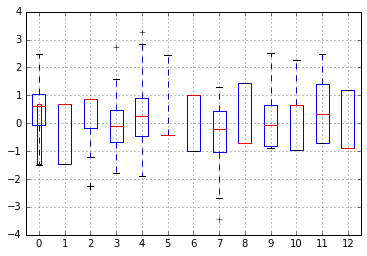

Hierarchical Cluster: 2
           0         1         2         3         4        5         6   \
6    0.825494 -1.446980  0.873880  0.468418  0.397801 -0.41145  1.010199   
27   1.268242 -1.446980 -2.240629  1.032342 -0.411292 -0.41145 -1.003419   
68   0.493433  0.691095  0.873880  2.160191  1.515120 -0.41145  1.010199   
90   0.825494 -1.446980  0.873880  1.596266 -1.605668 -0.41145  1.010199   
120  0.936181 -1.446980  0.873880  1.032342  3.075514 -0.41145  1.010199   
122  0.050685  0.691095  0.873880  0.468418 -0.584669 -0.41145 -1.003419   
135  1.710989  0.691095  0.873880  0.750380 -1.413027 -0.41145 -1.003419   
168  1.710989  0.691095 -0.164289  1.596266  0.417065 -0.41145 -1.003419   
179  0.161372 -1.446980  0.873880  0.130063  3.114042 -0.41145  1.010199   
181  0.493433  0.691095 -2.240629  2.611330  0.436329 -0.41145  1.010199   

           7         8         9         10        11        12  
6    0.454120 -0.696419  2.185652  2.264145  1.411625 -0.894220  
27  -1.

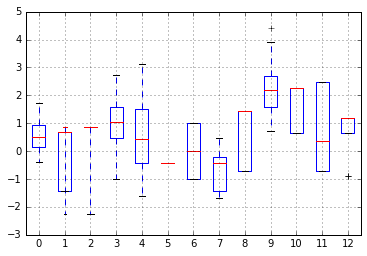

Hierarchical Cluster: 3
           0        1         2         3         4        5         6   \
151  1.378929 -1.44698 -0.164289 -0.941393  6.099981 -0.41145  1.010199   

          7         8         9         10        11        12  
151  0.45412 -0.696419  0.467672  0.643781 -0.721976  1.172577  


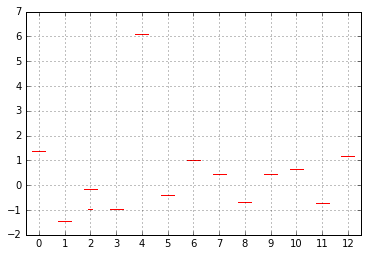

Hierarchical Cluster: 4
           0         1         2         3         4         5         6   \
0    0.936181  0.691095 -2.240629  0.750380 -0.276443  2.430427  1.010199   
9   -0.170689  0.691095  0.873880  0.468418 -0.854367  2.430427  1.010199   
12   0.161372  0.691095 -0.164289 -0.095506  0.166631  2.430427  1.010199   
31   0.604120  0.691095  0.873880 -0.828608 -0.334236  2.430427 -1.003419   
39   0.714807  0.691095 -0.164289  1.032342 -0.083802  2.430427 -1.003419   
49  -0.170689  0.691095 -0.164289 -0.095506 -0.969952  2.430427  1.010199   
83   1.489615  0.691095 -0.164289  2.724115  0.513386  2.430427  1.010199   
110  0.161372  0.691095  0.873880 -0.377469  0.031783  2.430427  1.010199   
112 -1.277559 -1.446980  0.873880  0.017278  1.804082  2.430427  1.010199   
117  0.936181  0.691095  0.873880 -0.095506  1.592176  2.430427  1.010199   

           7         8         9         10        11        12  
0    0.017494 -0.696419  1.068965  2.264145 -0.721976  0.65587

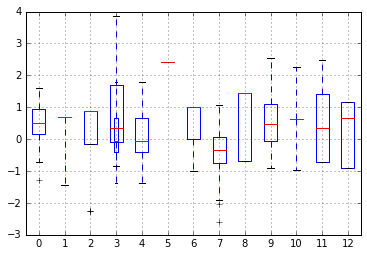

KMeans Cluster: 0
          0         1         2         3         4         5         6   \
0   0.936181  0.691095 -2.240629  0.750380 -0.276443  2.430427  1.010199   
12  0.161372  0.691095 -0.164289 -0.095506  0.166631  2.430427  1.010199   
14 -0.281376  0.691095 -0.164289  2.272976 -0.931424  2.430427 -1.003419   
21  0.382746 -1.446980 -2.240629  1.032342  0.686763  2.430427  1.010199   
31  0.604120  0.691095  0.873880 -0.828608 -0.334236  2.430427 -1.003419   
39  0.714807  0.691095 -0.164289  1.032342 -0.083802  2.430427 -1.003419   
43  0.493433  0.691095 -0.164289  1.032342 -0.680990  2.430427 -1.003419   
48  1.157555 -1.446980 -0.164289  0.468418  3.268155  2.430427  1.010199   
49 -0.170689  0.691095 -0.164289 -0.095506 -0.969952  2.430427  1.010199   
63 -0.060002 -1.446980 -0.164289  0.186456  1.091309  2.430427 -1.003419   

          7         8         9         10        11        12  
0   0.017494 -0.696419  1.068965  2.264145 -0.721976  0.655877  
12 -0.331806  1

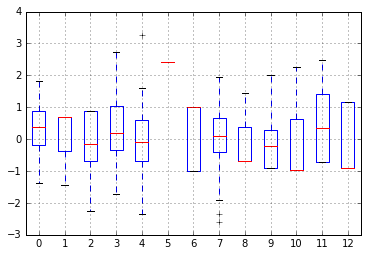

KMeans Cluster: 1
          0         1        2         3         4         5         6   \
1   1.378929  0.691095  0.87388  1.596266  0.744555 -0.411450  1.010199   
2   1.378929  0.691095  0.87388 -0.659431 -0.353500 -0.411450  1.010199   
9  -0.170689  0.691095  0.87388  0.468418 -0.854367  2.430427  1.010199   
24  0.604120  0.691095  0.87388 -0.095506 -0.796575 -0.411450  1.010199   
29 -1.609620  0.691095  0.87388 -1.223355 -1.547875 -0.411450  1.010199   
36 -1.277559  0.691095  0.87388 -0.659431 -1.355234 -0.411450  1.010199   
37  0.272059  0.691095  0.87388  1.032342  0.551914 -0.411450  1.010199   
38  0.050685  0.691095  0.87388  0.017278  2.035251 -0.411450 -1.003419   
54  0.604120  0.691095  0.87388 -0.095506  0.108839 -0.411450 -1.003419   
55 -0.060002  0.691095  0.87388 -0.433861  0.359273 -0.411450  1.010199   

          7         8         9         10        11        12  
1  -1.816334  1.435916  0.381773  0.643781  2.478425 -0.894220  
2  -0.899420  1.435916  1.

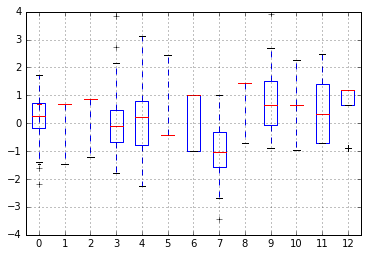

KMeans Cluster: 2
          0         1         2         3         4        5         6   \
7   0.272059 -1.446980  0.873880 -0.659431  2.054515 -0.41145 -1.003419   
11  0.161372 -1.446980 -1.202459  0.468418  0.898668 -0.41145  1.010199   
18 -0.724124 -1.446980 -0.164289 -0.095506  0.532650 -0.41145 -1.003419   
25 -0.502750 -1.446980 -0.164289 -0.659431 -0.546141 -0.41145 -1.003419   
26  0.382746 -1.446980 -0.164289 -0.659431  1.784818 -0.41145 -1.003419   
27  1.268242 -1.446980 -2.240629  1.032342 -0.411292 -0.41145 -1.003419   
30  1.600302 -1.446980 -2.240629  0.468418 -0.160859 -0.41145 -1.003419   
32  1.046868  0.691095 -0.164289  0.468418  1.688497 -0.41145 -1.003419   
42  1.821676 -1.446980 -1.202459  1.596266  1.052781 -0.41145 -1.003419   
44  0.714807 -1.446980  0.873880 -0.095506  1.592176 -0.41145  1.010199   

          7         8         9         10        11       12  
7   0.585108  1.435916 -0.391318 -0.976583 -0.721976 -0.89422  
11  0.148482 -0.696419  0.20

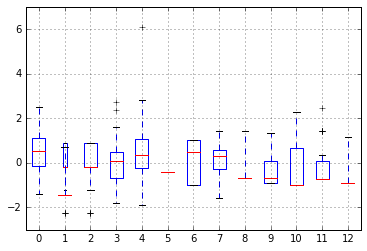

KMeans Cluster: 3
          0         1         2         3         4        5         6   \
6   0.825494 -1.446980  0.873880  0.468418  0.397801 -0.41145  1.010199   
8   0.936181  0.691095  0.873880 -0.095506  0.128103 -0.41145  1.010199   
10  0.272059  0.691095  0.873880  0.468418 -1.066272 -0.41145 -1.003419   
23  0.382746  0.691095 -0.164289  0.017278 -0.449820 -0.41145  1.010199   
33  0.493433  0.691095  0.873880  0.186456 -0.257179 -0.41145 -1.003419   
40  1.157555 -1.446980  0.873880  1.032342 -0.430556 -0.41145  1.010199   
45  0.382746  0.691095 -0.164289 -1.110570 -0.334236 -0.41145  1.010199   
47 -0.502750  0.691095  0.873880  1.032342 -0.083802 -0.41145  1.010199   
51  1.157555  0.691095  0.873880 -0.659431 -1.355234 -0.41145 -1.003419   
56 -0.502750  0.691095 -0.164289  0.468418 -0.276443 -0.41145 -1.003419   

          7         8         9         10        11        12  
6   0.454120 -0.696419  2.185652  2.264145  1.411625 -0.894220  
8  -0.113493 -0.696419  0.

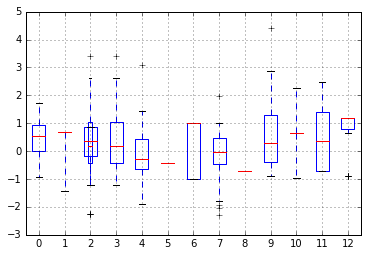

KMeans Cluster: 4
          0         1         2         3         4        5         6   \
3  -1.941680  0.691095 -0.164289 -0.095506  0.051047 -0.41145 -1.003419   
4  -1.498933 -1.446980 -1.202459 -0.095506 -0.835103 -0.41145  1.010199   
5   0.161372  0.691095 -1.202459 -0.659431 -0.218651 -0.41145 -1.003419   
13 -1.166872  0.691095 -1.202459 -0.659431  0.301480 -0.41145 -1.003419   
15  0.272059  0.691095 -0.164289  1.032342 -1.528611 -0.41145 -1.003419   
16 -0.724124  0.691095 -1.202459 -1.223355 -0.353500 -0.41145 -1.003419   
17 -0.060002  0.691095  0.873880  0.468418 -0.160859 -0.41145 -1.003419   
19 -0.613437  0.691095 -1.202459 -0.095506  0.359273 -0.41145 -1.003419   
20  1.046868  0.691095 -2.240629 -1.223355 -0.700254 -0.41145  1.010199   
22  0.382746  0.691095 -1.202459 -0.659431  0.706027 -0.41145  1.010199   

          7         8         9         10        11        12  
3   1.633010 -0.696419  2.099753  2.264145 -0.721976 -0.894220  
4   0.978071 -0.696419  0.

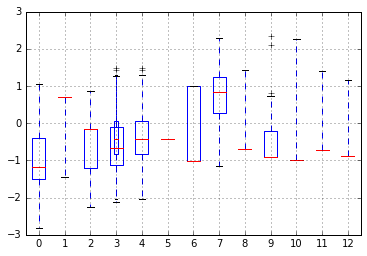

GMM Cluster: 0
          0         1        2         3         4        5         6   \
1   1.378929  0.691095  0.87388  1.596266  0.744555 -0.41145  1.010199   
2   1.378929  0.691095  0.87388 -0.659431 -0.353500 -0.41145  1.010199   
6   0.825494 -1.446980  0.87388  0.468418  0.397801 -0.41145  1.010199   
24  0.604120  0.691095  0.87388 -0.095506 -0.796575 -0.41145  1.010199   
29 -1.609620  0.691095  0.87388 -1.223355 -1.547875 -0.41145  1.010199   
36 -1.277559  0.691095  0.87388 -0.659431 -1.355234 -0.41145  1.010199   
37  0.272059  0.691095  0.87388  1.032342  0.551914 -0.41145  1.010199   
38  0.050685  0.691095  0.87388  0.017278  2.035251 -0.41145 -1.003419   
40  1.157555 -1.446980  0.87388  1.032342 -0.430556 -0.41145  1.010199   
47 -0.502750  0.691095  0.87388  1.032342 -0.083802 -0.41145  1.010199   

          7         8         9         10        11        12  
1  -1.816334  1.435916  0.381773  0.643781  2.478425 -0.894220  
2  -0.899420  1.435916  1.326662  0.6437

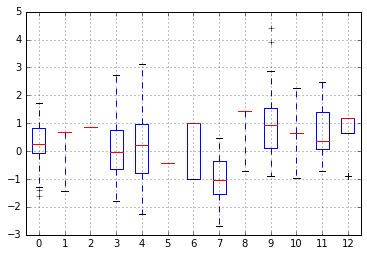

GMM Cluster: 1
          0         1         2         3         4        5         6   \
3  -1.941680  0.691095 -0.164289 -0.095506  0.051047 -0.41145 -1.003419   
4  -1.498933 -1.446980 -1.202459 -0.095506 -0.835103 -0.41145  1.010199   
5   0.161372  0.691095 -1.202459 -0.659431 -0.218651 -0.41145 -1.003419   
11  0.161372 -1.446980 -1.202459  0.468418  0.898668 -0.41145  1.010199   
15  0.272059  0.691095 -0.164289  1.032342 -1.528611 -0.41145 -1.003419   
17 -0.060002  0.691095  0.873880  0.468418 -0.160859 -0.41145 -1.003419   
18 -0.724124 -1.446980 -0.164289 -0.095506  0.532650 -0.41145 -1.003419   
19 -0.613437  0.691095 -1.202459 -0.095506  0.359273 -0.41145 -1.003419   
22  0.382746  0.691095 -1.202459 -0.659431  0.706027 -0.41145  1.010199   
25 -0.502750 -1.446980 -0.164289 -0.659431 -0.546141 -0.41145 -1.003419   

          7         8         9         10        11       12  
3   1.633010 -0.696419  2.099753  2.264145 -0.721976 -0.89422  
4   0.978071 -0.696419  0.29587

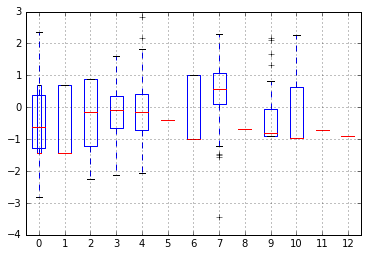

GMM Cluster: 2
          0         1         2         3         4        5         6   \
8   0.936181  0.691095  0.873880 -0.095506  0.128103 -0.41145  1.010199   
10  0.272059  0.691095  0.873880  0.468418 -1.066272 -0.41145 -1.003419   
13 -1.166872  0.691095 -1.202459 -0.659431  0.301480 -0.41145 -1.003419   
16 -0.724124  0.691095 -1.202459 -1.223355 -0.353500 -0.41145 -1.003419   
20  1.046868  0.691095 -2.240629 -1.223355 -0.700254 -0.41145  1.010199   
23  0.382746  0.691095 -0.164289  0.017278 -0.449820 -0.41145  1.010199   
33  0.493433  0.691095  0.873880  0.186456 -0.257179 -0.41145 -1.003419   
34 -1.166872  0.691095 -0.164289 -0.095506 -0.276443 -0.41145 -1.003419   
41 -1.609620  0.691095 -2.240629  0.468418 -0.931424 -0.41145 -1.003419   
45  0.382746  0.691095 -0.164289 -1.110570 -0.334236 -0.41145  1.010199   

          7         8         9         10        11        12  
8  -0.113493 -0.696419  0.295874  0.643781  0.344824  1.172577  
10 -0.069831 -0.696419 -0.563

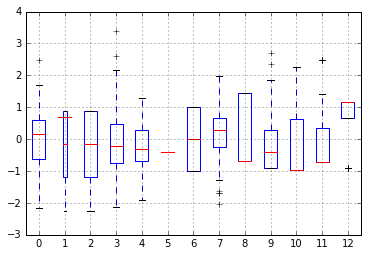

GMM Cluster: 3
          0         1         2         3         4         5         6   \
0   0.936181  0.691095 -2.240629  0.750380 -0.276443  2.430427  1.010199   
9  -0.170689  0.691095  0.873880  0.468418 -0.854367  2.430427  1.010199   
12  0.161372  0.691095 -0.164289 -0.095506  0.166631  2.430427  1.010199   
14 -0.281376  0.691095 -0.164289  2.272976 -0.931424  2.430427 -1.003419   
21  0.382746 -1.446980 -2.240629  1.032342  0.686763  2.430427  1.010199   
31  0.604120  0.691095  0.873880 -0.828608 -0.334236  2.430427 -1.003419   
39  0.714807  0.691095 -0.164289  1.032342 -0.083802  2.430427 -1.003419   
43  0.493433  0.691095 -0.164289  1.032342 -0.680990  2.430427 -1.003419   
48  1.157555 -1.446980 -0.164289  0.468418  3.268155  2.430427  1.010199   
49 -0.170689  0.691095 -0.164289 -0.095506 -0.969952  2.430427  1.010199   

          7         8         9         10        11        12  
0   0.017494 -0.696419  1.068965  2.264145 -0.721976  0.655877  
9   0.235807  1.43

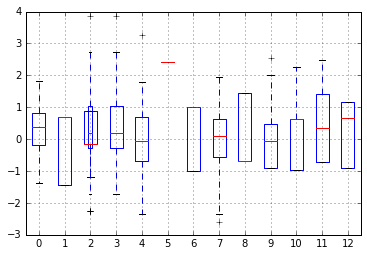

GMM Cluster: 4
           0        1         2         3         4        5         6   \
7    0.272059 -1.44698  0.873880 -0.659431  2.054515 -0.41145 -1.003419   
30   1.600302 -1.44698 -2.240629  0.468418 -0.160859 -0.41145 -1.003419   
42   1.821676 -1.44698 -1.202459  1.596266  1.052781 -0.41145 -1.003419   
50  -1.498933 -1.44698 -1.202459 -1.505317 -0.950688 -0.41145 -1.003419   
61  -0.945498 -1.44698 -0.164289  0.581203 -1.355234 -0.41145  1.010199   
77  -0.392063 -1.44698 -0.164289  0.468418  1.168366 -0.41145  1.010199   
101  0.272059 -1.44698  0.873880 -0.208291  1.072045 -0.41145  1.010199   
113  0.825494 -1.44698 -0.164289 -0.095506  0.301480 -0.41145 -1.003419   
148  0.604120 -1.44698 -0.164289 -1.674494  1.361007 -0.41145 -1.003419   
151  1.378929 -1.44698 -0.164289 -0.941393  6.099981 -0.41145  1.010199   

           7         8         9         10        11        12  
7    0.585108  1.435916 -0.391318 -0.976583 -0.721976 -0.894220  
30   0.061157 -0.696419  0.

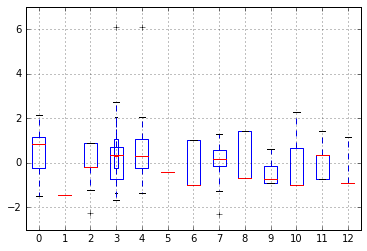

In [17]:
# # Part #4 Attribute difference
from sklearn import mixture, cluster

clusterers = {
    'KMeans':cluster.KMeans(n_clusters=5, init='random', random_state=20160217),
    'Hierarchical':cluster.AgglomerativeClustering(n_clusters=5, linkage='complete'),
    'GMM':mixture.GMM(n_components=5, random_state=20160217),
    }

clusterings = {'True':heart_labels}

for clusterer in clusterers.iterkeys():
    clusterings[clusterer]=clusterers[clusterer].fit_predict(heart_processed)

pnum = 1
for clusterer in clusterers.iterkeys():
    for i in range(0, 5):
        cluster_index = []
        for instance in range(0, len(clusterings[clusterer])):
            if i == clusterings[clusterer][instance]:
                cluster_index.append(instance)

        print str(clusterer) + " Cluster: " + str(i)

        df = pd.DataFrame(heart_processed.iloc[cluster_index])
        print df.head(10)

            
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.boxplot(df.ix[:, i].values, positions = [i])

        df.boxplot(return_type='axes')

    #     ax.set_xlim(-0.5, 9.5)
        plt.show()
            
            

Model: Hierarchical
Model: KMeans
Model: GMM


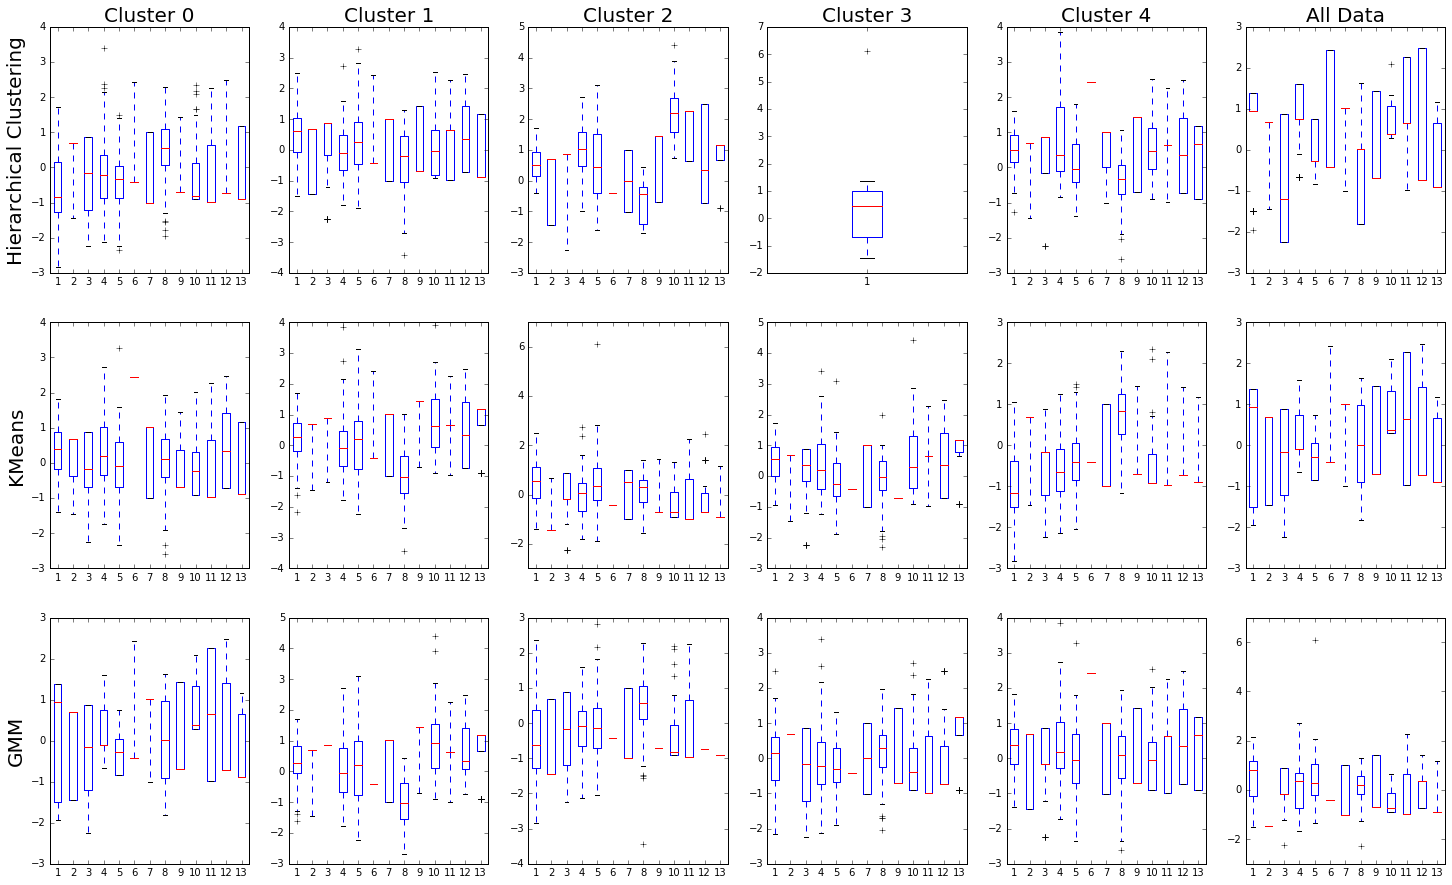

In [18]:
# # Part #5 Plotting boxplots of attributes
from sklearn import mixture, cluster

clusterers = {
    'KMeans':cluster.KMeans(n_clusters=5, init='random', random_state=20160217),
    'Hierarchical':cluster.AgglomerativeClustering(n_clusters=5, linkage='complete'),
    'GMM':mixture.GMM(n_components=5, random_state=20160217),
    }

clusterings = {'True':heart_labels}

for clusterer in clusterers.iterkeys():
    clusterings[clusterer]=clusterers[clusterer].fit_predict(heart_processed)

all_values = []

for clusterer in clusterers.iterkeys():
    print "Model: " + clusterer
    for i in range(0, 5):
        cluster_index = []
        for instance in range(0, len(clusterings[clusterer])):
            if i == clusterings[clusterer][instance]:
                cluster_index.append(instance)

        df = pd.DataFrame(heart_processed.iloc[cluster_index])
#         print "Cluster: " + str(i)
#         print df.head(10)
        all_values.append(df)
    
    all_values.append(pd.DataFrame(heart_processed.iloc[clusterings[clusterer]]))

font = 20
small_font = 20
f, ax = plt.subplots(3, 6, figsize=(25,15))
ax[0][0].boxplot(all_values[0].values)
ax[0][0].set_title("Cluster 0", fontsize=small_font)
ax[0][0].set_ylabel("Hierarchical Clustering", fontsize=font)

ax[0][1].boxplot(all_values[1].values)
ax[0][1].set_title("Cluster 1", fontsize=small_font)

ax[0][2].boxplot(all_values[2].values)
ax[0][2].set_title("Cluster 2", fontsize=small_font)

ax[0][3].boxplot(all_values[3].values)
ax[0][3].set_title("Cluster 3", fontsize=small_font)

ax[0][4].boxplot(all_values[4].values)
ax[0][4].set_title("Cluster 4", fontsize=small_font)

ax[0][5].boxplot(all_values[5].values)
ax[0][5].set_title("All Data", fontsize=small_font)

ax[1][0].boxplot(all_values[6].values)
ax[1][0].set_ylabel("KMeans", fontsize=font)
ax[1][1].boxplot(all_values[7].values)
ax[1][2].boxplot(all_values[8].values)
ax[1][3].boxplot(all_values[9].values)
ax[1][4].boxplot(all_values[10].values)
ax[1][5].boxplot(all_values[11].values)

ax[2][0].boxplot(all_values[11].values)
ax[2][0].set_ylabel("GMM", fontsize=font)
ax[2][1].boxplot(all_values[12].values)
ax[2][2].boxplot(all_values[13].values)
ax[2][3].boxplot(all_values[14].values)
ax[2][4].boxplot(all_values[15].values)
ax[2][5].boxplot(all_values[16].values)
        
plt.show()
            

## Question 3: Clustering Census Data (15 points)
This question is a bit trickier. You'll be clustering data with a mix of numeric and nominal attributes. I've encoded the one ordinal attribute for you.  You'll be looking at a few different techniques to work with this sort of data.
1.   Using census_data_scaled, run KMeans and GMM clustering, while increasing the number of clusters to 100 taking steps of 4 (e.g. range(1,100,4)). Plot the WSS with respect to the number of clusters. It may also be helpful to plot the change in WSS as the number of clusters increase. Where does the WSS error seem to plateau? 
2.   One of the issues we've noted is that distance functions often behave nonintuitively in very high dimensions. Let's try to address this problem in a couple of ways.  One option is to project into a lower dimensional space. We used PCA for this in Assignment 1. 
   * Project the census data into a 3-dimensional space and a 7-dimensional space using PCA. 
   * Repeat the clustering experiment, plotting the WSS for both settings. Do you notice a difference in how the WSS decreases? 
   * Choose a value for the number of clusters based on the plot. Pick one of the clusters from the 7D decomposition in PCA space and examine that cluster in the original attribute space. What are the salient attribute values for that cluster?
3. In some cases, the data is naturally high-dimensional. However, in this situation the high dimensionality of the data is the consequence of our preprocessing. Many of the attributes in the data arise from nominal attributes that have been translated into a OneHot encoding. If these nominal attributes could be encoded more densely, our clusterings might be more useful. We can try to encode the nominal attributes with many values (WorkClass, MaritalStatus, Occupation, NativeCountry) in the original data differently. You could, for example, encode Marital Status as Married or Single, re-encode countries into continents, re-encode WorkClass into Government/non-Government, and Occupation into white-collar or blue-collar. These are just examples, and you can choose your own encoding strategy. 
   * Re-encode the nominal attributes using a scheme of your choice
   * Repeat the experiment, plotting the WSS again. What do you notice? 
   * Choose a number of clusters based on the WSS plot. Pick one cluster and report the salient attributes for that cluster.
   


<h1> Answers 3 </h1>
<p> 1. The WSS error seems to plateau around 70 clusters for GMM and around 80 for KMeans </p>
<p> 2. The WSS values decrease very differently than the high dimensinality data. <br>
Furhtermoer, between the 3 and 7 D data, the error decreases at the same speed, but at different values. The shape is the same while the actual error values are different. Higher for the 7D data. <br>
Also when performing PCA the error starts to plateau much earlier, at around 10 clusters. Furhtermore, the lower the dimensinality of the data, the lower the WSS error. <br>
For PCA 3 dimensions, the error starts out at 300,000 and goes down to 9000 for each <br>
For PCA 7 dimesions, the error starts out at around 600,000 and goes down to about 50,000, so not as low as the lower dimensional PCA 3. <br>
<br>
Plotting one of the clusters of the 7D space and the equivalent cluster with 88 features, we see that only few features have a good feature value distribution. Most features in the original dataset are have a very small range of values. There are 9 features which are relevant: 0, 3, 4, 5, 6, 54, 74, 77 and 82. We see that the choice of a 7D PCA is good, though we could have probably increased it to 9 capture the 2 additional features that might have contributed to the clustering. 
</p>

<p> 3. Reencoding the high dimensional nominal values and plotting the WSS we notice that the plot starts to look very
similar to the plot of the PCA WSS error. This makes sense, because with the reenconding we are doing the same as what PCA does, reduces the dimensionality of the attributes. Thus the simiar shape makes sense. <br>
It's important to note that the WSS error is much higher than the PCA, yet lower than performing one-hot encoding. <br>
Salient attributes: 0, 3, 4, 8, 10, 57, 70, 72, 73, 79, 80, 83 </p>


In [19]:
census_data = urllib2.urlopen("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data")
census_orig = pd.read_csv(census_data, quotechar='"', skipinitialspace=True, 
                               names=['Age','WorkClass', 'FnlWgt', 'Education', 'EducationYears', 'MaritalStatus', 
                                      'Occupation', 'Relationship', 'Race', 'Sex', 
                                      'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 
                                      'NativeCountry', 'Label'],
                               na_values="?", index_col=False)

census_orig = census_orig.dropna()
census_orig = census_orig.drop('FnlWgt',1)
education_translation = {'Preschool':0,
                        '1st-4th':1,
                         '5th-6th':2,
                         '7th-8th':3,
                         '9th':4,
                         '10th':5,
                         '11th':6,
                         '12th':7,
                         'HS-grad':8,
                         'Some-college':9,
                         'Assoc-voc':10,
                         'Assoc-acdm':11,
                         'Bachelors':12,
                         'Masters':13,
                         'Prof-school':14,
                         'Doctorate':15
                        }
census_orig['Education'] = census_orig['Education'].apply(lambda x: education_translation[x])

# Convert labels from strings to boolean
label_encoder = preprocessing.LabelEncoder()
census_labels = pd.DataFrame(label_encoder.fit_transform(census_orig.iloc[:,-1]))

# Convert nominal attributes to encoded versions
attr_encoder = feature_extraction.DictVectorizer(sparse=False)
census_data = pd.DataFrame(attr_encoder.fit_transform(census_orig.iloc[:,:-1].T.to_dict().values()))
census_data.columns = attr_encoder.get_feature_names()

census_data_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(census_data.values))
#census_data_scaled.columns = attr_encoder.get_feature_names()


In [20]:
# Part 1
from sklearn import mixture, cluster

def wss(kmeans, cluster_size):
    wss = 0
    # Iterate over each cluster
    for cluster in range(0, cluster_size):
        cluster_instances = []
        # Iterate over each instance of the dataset
        for i in range(0, len(kmeans)):
            # If that dataset instance is in the right cluster
            if (kmeans[i] == cluster):
                cluster_instances.append(i)


        census_cluster = census_data_scaled.iloc[cluster_instances]
        cols = census_cluster.shape[1]
        
        for col in range(0, cols):
            feature_vals = census_cluster[col].values
            attr_mean = 0
            for i in range(0, len(feature_vals)):
                attr_mean += feature_vals[i]
            
            attr_mean = float(attr_mean / float(len(feature_vals)))
            
            for i in range(0, len(feature_vals)):
                point = (feature_vals[i] - attr_mean)**2
                wss+= point
    return wss

cluster_size = []
kmeans_wss_vals = []
gmm_wss_vals = []
for cluster_num in range(1, 100, 4):
    km = cluster.KMeans(n_clusters=cluster_num, init='random', random_state=20160217)
    gmm = mixture.GMM(n_components=cluster_num, random_state=20160217)

    kmeans_wss = wss(km.fit_predict(census_data_scaled), cluster_num)
    gmm_wss = wss(gmm.fit_predict(census_data_scaled), cluster_num)
    
    cluster_size.append(cluster_num)
    kmeans_wss_vals.append(kmeans_wss)
    gmm_wss_vals.append(gmm_wss)
    
    print "Cluster: " + str(cluster_num)
    print "KM wss : " + str(kmeans_wss) + " GMM wss: " + str(gmm_wss)

Cluster: 1
KM wss : 2654256.00002 GMM wss: 2654256.00002
Cluster: 5
KM wss : 2413587.05166 GMM wss: 2403845.90346
Cluster: 9
KM wss : 2257288.92756 GMM wss: 2275604.63554
Cluster: 13
KM wss : 2159732.92708 GMM wss: 2164168.37649
Cluster: 17
KM wss : 2065185.73405 GMM wss: 2069432.46524
Cluster: 21
KM wss : 1982692.4696 GMM wss: 1917221.74872
Cluster: 25
KM wss : 1905639.43897 GMM wss: 1830700.96148
Cluster: 29
KM wss : 1808786.1577 GMM wss: 1702252.06306
Cluster: 33
KM wss : 1752780.28775 GMM wss: 1576220.37798
Cluster: 37
KM wss : 1672867.74956 GMM wss: 1479942.97078
Cluster: 41
KM wss : 1629500.98015 GMM wss: 1345238.04516
Cluster: 45
KM wss : 1542574.00487 GMM wss: 1221620.49957
Cluster: 49
KM wss : 1448685.99897 GMM wss: 1123931.39958
Cluster: 53
KM wss : 1404466.77561 GMM wss: 1000544.07076
Cluster: 57
KM wss : 1293064.34984 GMM wss: 898638.329022
Cluster: 61
KM wss : 1254866.25114 GMM wss: 840297.592565
Cluster: 65
KM wss : 1243397.80166 GMM wss: 735228.388188
Cluster: 69
KM wss 

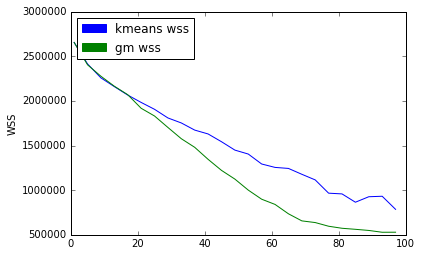

In [21]:
plt.plot(cluster_size, kmeans_wss_vals, 'b', cluster_size, gmm_wss_vals, 'g')
blue_patch = mpatches.Patch(color='blue', label='kmeans wss')
green_patch = mpatches.Patch(color='green', label='gm wss')

plt.legend(handles=[blue_patch, green_patch], loc='upper left')

plt.ylabel("WSS")
plt.show()


          0         1         2
0  0.607939 -2.269147 -0.763535
1 -2.788245 -1.317830 -0.023245
2  0.803568  0.708483 -1.199120
3 -0.901320  2.529662  1.173713
4  1.204012 -1.421205  4.418078
-----------PCA VALUES------------
Cluster: 1
KM wss : 304659.136888 GMM wss: 304659.136888
Cluster: 5
KM wss : 96032.5125022 GMM wss: 123704.17403
Cluster: 9
KM wss : 57337.0908372 GMM wss: 77060.8308305
Cluster: 13
KM wss : 42569.6730684 GMM wss: 59749.8019737
Cluster: 17
KM wss : 34404.8244546 GMM wss: 45424.5730271
Cluster: 21
KM wss : 28910.7311625 GMM wss: 39878.0591016
Cluster: 25
KM wss : 25178.0482025 GMM wss: 37192.1741238
Cluster: 29
KM wss : 22388.6911411 GMM wss: 33357.8453997
Cluster: 33
KM wss : 20720.9293346 GMM wss: 31064.6806697
Cluster: 37
KM wss : 18869.0939049 GMM wss: 29592.1449597
Cluster: 41
KM wss : 17442.4623923 GMM wss: 27061.9355364
Cluster: 45
KM wss : 16289.070252 GMM wss: 26403.8788113
Cluster: 49
KM wss : 15342.8269028 GMM wss: 25622.0442064
Cluster: 53
KM wss : 1452

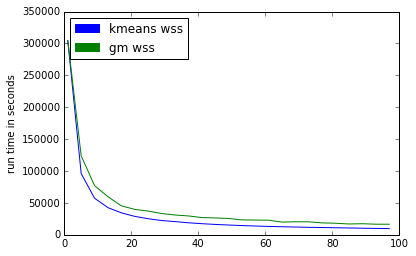

          0         1         2         3         4         5         6
0  0.607939 -2.269147 -0.763535  1.360590 -0.782690 -1.889694 -0.572049
1 -2.788245 -1.317830 -0.023245 -0.209085 -0.328010 -0.509259 -1.239226
2  0.803568  0.708483 -1.199120 -0.276066  0.336155 -1.341190  2.139172
3 -0.901320  2.529662  1.173713 -0.648880 -3.038289  1.467002  1.158316
4  1.204012 -1.421205  4.418078  0.123548  1.472908  2.488223 -2.084141
-----------PCA VALUES------------
Cluster: 1
KM wss : 531780.675644 GMM wss: 531780.675644
Cluster: 5
KM wss : 288863.707382 GMM wss: 332772.115569
Cluster: 9
KM wss : 194777.021722 GMM wss: 214440.735736
Cluster: 13
KM wss : 156218.276029 GMM wss: 181784.370583
Cluster: 17
KM wss : 133779.584715 GMM wss: 158381.643779
Cluster: 21
KM wss : 118918.354128 GMM wss: 142873.48907
Cluster: 25
KM wss : 108698.145359 GMM wss: 128234.688623
Cluster: 29
KM wss : 99581.11098 GMM wss: 122115.019662
Cluster: 33
KM wss : 92058.543316 GMM wss: 117043.179114
Cluster: 37
KM wss 

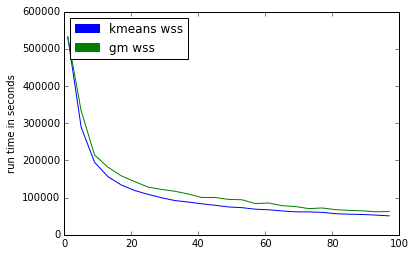

In [22]:
# Part 2
from sklearn.decomposition import PCA

def wss(kmeans, cluster_size, census_data_scaled):
    wss = 0
    # Iterate over each cluster
    for cluster in range(0, cluster_size):
        cluster_instances = []
        # Iterate over each instance of the dataset
        for i in range(0, len(kmeans)):
            # If that dataset instance is in the right cluster
            if (kmeans[i] == cluster):
                cluster_instances.append(i)


        census_cluster = census_data_scaled.iloc[cluster_instances]
        cols = census_cluster.shape[1]
        
        for col in range(0, cols):
            feature_vals = census_cluster[col].values
            attr_mean = 0
            for i in range(0, len(feature_vals)):
                attr_mean += feature_vals[i]
            
            if len(feature_vals) == 0:
                attr_mean = 0
            else:
                attr_mean = float(attr_mean / float(len(feature_vals)))
            
            for i in range(0, len(feature_vals)):
                point = (feature_vals[i] - attr_mean)**2
                wss+= point
    return wss

pca_3 = pd.DataFrame(PCA(n_components=3).fit_transform(census_data_scaled.values))
pca_7 = pd.DataFrame(PCA(n_components=7).fit_transform(census_data_scaled.values))


pca_list = [pca_3, pca_7]

for pca_data in pca_list:

    pca_cluster_size = []
    pca_kmeans_wss_vals = []
    pca_gmm_wss_vals = []
    print pca_data.head()
    print "-----------PCA VALUES------------"
    for cluster_num in range(1, 100, 4):
        km = cluster.KMeans(n_clusters=cluster_num, init='random', random_state=20160217)
        gmm = mixture.GMM(n_components=cluster_num, random_state=20160217)

        kmeans_wss = wss(km.fit_predict(pca_data), cluster_num, pca_data)
        gmm_wss = wss(gmm.fit_predict(pca_data), cluster_num, pca_data)

        pca_cluster_size.append(cluster_num)
        pca_kmeans_wss_vals.append(kmeans_wss)
        pca_gmm_wss_vals.append(gmm_wss)

        print "Cluster: " + str(cluster_num)
        print "KM wss : " + str(kmeans_wss) + " GMM wss: " + str(gmm_wss)

    plt.plot(pca_cluster_size, pca_kmeans_wss_vals, 'b', pca_cluster_size, pca_gmm_wss_vals, 'g')
    blue_patch = mpatches.Patch(color='blue', label='kmeans wss')
    green_patch = mpatches.Patch(color='green', label='gm wss')

    plt.legend(handles=[blue_patch, green_patch], loc='upper left')

    plt.ylabel("run time in seconds")
    plt.show()



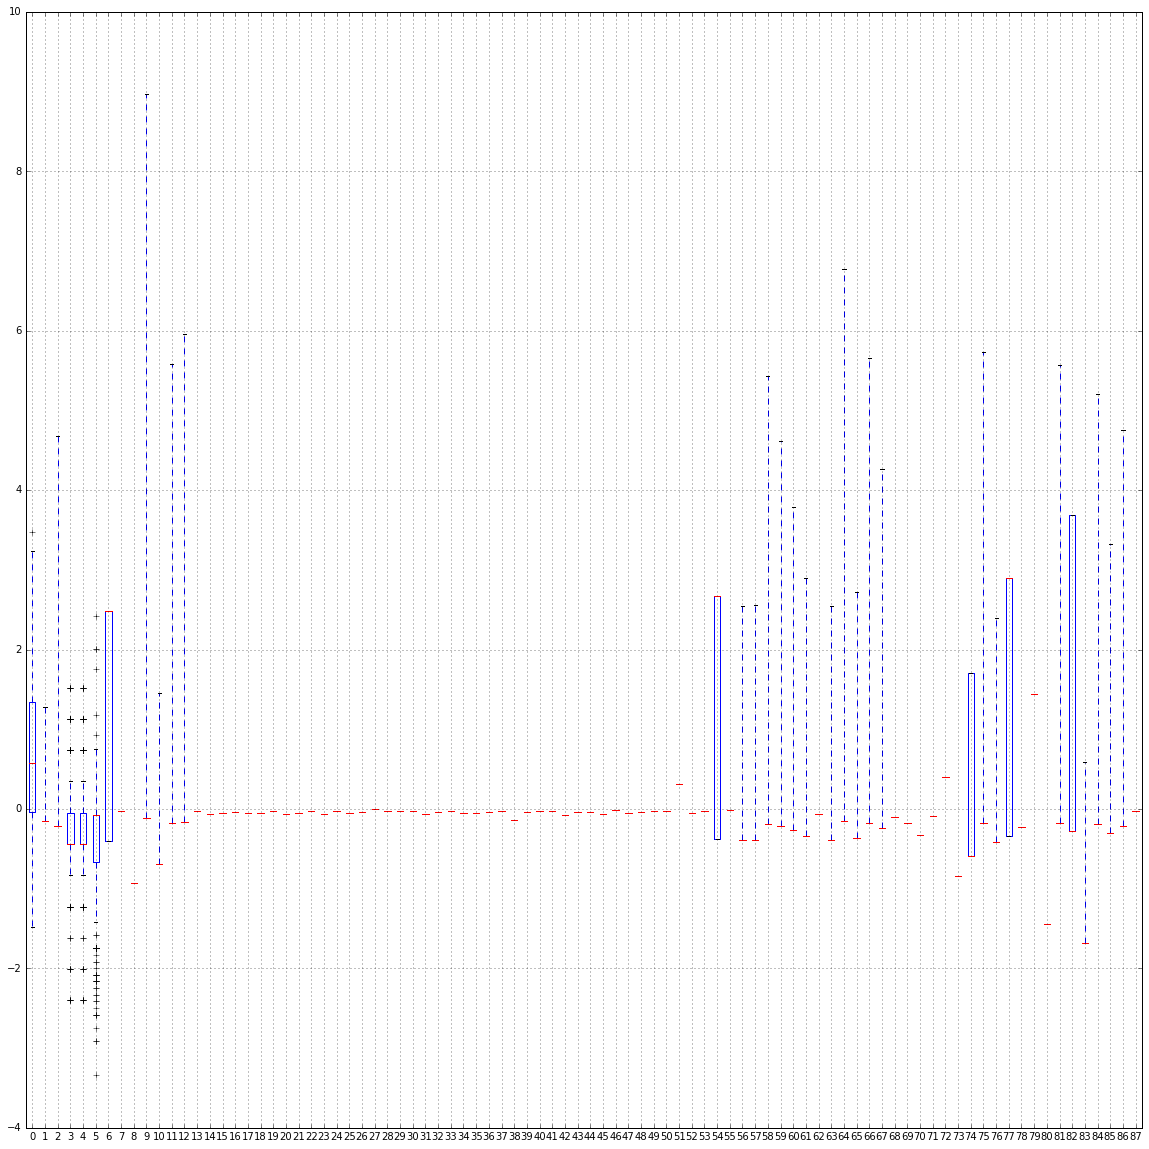

In [23]:
# Part 2 salient attribute
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_data = pd.DataFrame(PCA(n_components=7).fit_transform(census_data_scaled.values))
cluster_size = 40

gmm = mixture.GMM(n_components=cluster_size, random_state=20160217)

gmm_predict_pca = gmm.fit_predict(pca_data)

cluster_instances = []
# Iterate over each instance of the dataset
for i in range(0, len(gmm_predict_pca)):
    # If that dataset instance is in the right cluster
    if (gmm_predict_pca[i] == 5):
        cluster_instances.append(i)

pca_cluster = pca_data.iloc[cluster_instances]
normal_cluster = census_data_scaled.iloc[cluster_instances]

plt.figure(figsize=(20,20))
               
normal_cluster.boxplot(return_type='axes')

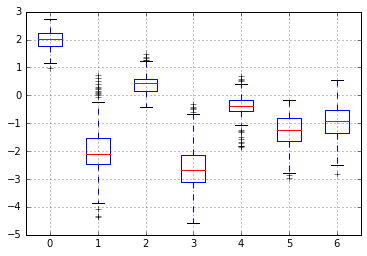

In [24]:
# Part 2 PCA boxplot
pca_cluster.boxplot(return_type='axes')

In [25]:
# Part 3
census_data = urllib2.urlopen("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data")
census_orig = pd.read_csv(census_data, quotechar='"', skipinitialspace=True, 
                               names=['Age','WorkClass', 'FnlWgt', 'Education', 'EducationYears', 'MaritalStatus', 
                                      'Occupation', 'Relationship', 'Race', 'Sex', 
                                      'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 
                                      'NativeCountry', 'Label'],
                               na_values="?", index_col=False)

census_orig = census_orig.dropna()
census_orig = census_orig.drop('FnlWgt',1)
education_translation = {'Preschool':0,
                        '1st-4th':1,
                         '5th-6th':2,
                         '7th-8th':3,
                         '9th':4,
                         '10th':5,
                         '11th':6,
                         '12th':7,
                         'HS-grad':8,
                         'Some-college':9,
                         'Assoc-voc':10,
                         'Assoc-acdm':11,
                         'Bachelors':12,
                         'Masters':13,
                         'Prof-school':14,
                         'Doctorate':15
                        }
census_orig['Education'] = census_orig['Education'].apply(lambda x: education_translation[x])

In [26]:

martial_status_translation = {'Separated':0,
                         'Widowed':0,
                         'Divorced':0,
                         'Married-spouse-absent':1,
                         'Never-married':0,
                         'Married-AF-spouse':1,
                         'Married-civ-spouse':1
                        }

relationship_translation = {'Own-child':1,
                         'Wife':1,
                         'Unmarried':0,
                         'Other-relative':1,
                         'Husband':1,
                         'Not-in-family': 0
                        }

work_class_translation = {'Self-emp-inc':'Non-Government',
                         'State-gov':'Government',
                         'Without-pay':'Non-Government',
                         'Private':'Non-Government',
                         'Local-gov':'Government',
                         'Self-emp-not-inc':'Non-Government',
                         'Federal-gov':'Government'
                        }
occupation_translation = {'Farming-fishing':'blue-collar',
                             'Armed-Forces':'blue-collar',
                              'Craft-repair':'blue-collar',
                              'Other-service':'white-collar',
                              'Transport-moving':'blue-collar',
                              'Prof-specialty':'white-collar',
                              'Sales':'white-collar',
                              'Exec-managerial':'white-collar',
                              'Handlers-cleaners':'blue-collar',
                              'Adm-clerical':'white-collar',
                              'Protective-serv':'white-collar',
                              'Tech-support':'white-collar',
                              'Priv-house-serv':'blue-collar',
                              'Machine-op-inspct':'white-collar'
                              }
native_country_transformation = {'Canada': 'NA',
                                 'Hong': 'ASIA',
                                 'Dominican-Republic': 'CA',
                                 'Italy': 'EUROPE',
                                 'Ireland': 'EUROPE',
                                 'Outlying-US(Guam-USVI-etc)': 'ASIA',
                                 'Scotland': 'EUROPE',
                                 'Cambodia': 'ASIA',
                                 'France': 'EUROPE',
                                 'Peru': 'SA',
                                 'Laos': 'ASIA',
                                 'Ecuador': 'CA',
                                 'Iran': 'ASIA',
                                 'Cuba': 'CA',
                                 'Guatemala': 'SA',
                                 'Germany': 'EUROPE',
                                 'Thailand': 'ASIA',
                                 'Haiti': 'CA',
                                 'Poland': 'EUROPE',
                                 'Holand-Netherlands': 'EUROPE',
                                 'Philippines': 'ASIA',
                                 'Vietnam': 'ASIA',
                                 'Hungary': 'EUROPE',
                                 'England': 'EUROPE',
                                 'South': 'CA',
                                 'Jamaica': 'CA',
                                 'Honduras': 'CA',
                                 'Portugal': 'EUROPE',
                                 'Mexico': 'CA',
                                 'El-Salvador': 'SA',
                                 'India': 'ASIA',
                                 'Puerto-Rico': 'CA',
                                 'China': 'ASIA',
                                 'Yugoslavia': 'EUROPE',
                                 'United-States': 'NA',
                                 'Trinadad&Tobago': 'CA',
                                 'Greece': 'EUROPE',
                                 'Japan': 'ASIA',
                                 'Taiwan': 'ASIA',
                                 'Nicaragua': 'CA',
                                 'Columbia': 'SA'}
                        
census_orig['MaritalStatus'] = census_orig['MaritalStatus'].apply(lambda x: martial_status_translation[x])
census_orig['Relationship'] = census_orig['Relationship'].apply(lambda x: relationship_translation[x])
census_orig['WorkClass'] = census_orig['WorkClass'].apply(lambda x: work_class_translation[x])
census_orig['Occupation'] = census_orig['Occupation'].apply(lambda x: occupation_translation[x])
census_orig['NativeCountry'] = census_orig['NativeCountry'].apply(lambda x: native_country_transformation[x])

In [27]:
# Convert labels from strings to boolean
label_encoder = preprocessing.LabelEncoder()
census_labels = pd.DataFrame(label_encoder.fit_transform(census_orig.iloc[:,-1]))

# Convert nominal attributes to encoded versions
attr_encoder = feature_extraction.DictVectorizer(sparse=False)
census_data = pd.DataFrame(attr_encoder.fit_transform(census_orig.iloc[:,:-1].T.to_dict().values()))
census_data.columns = attr_encoder.get_feature_names()

census_data_scaled_transformed = pd.DataFrame(preprocessing.StandardScaler().fit_transform(census_data.values))
#census_data_scaled.columns = attr_encoder.get_feature_names()

In [29]:
# Part 3 Plotting wss
from sklearn import mixture, cluster

def wss(kmeans, cluster_size):
    wss = 0
    # Iterate over each cluster
    for cluster in range(0, cluster_size):
        cluster_instances = []
        # Iterate over each instance of the dataset
        for i in range(0, len(kmeans)):
            # If that dataset instance is in the right cluster
            if (kmeans[i] == cluster):
                cluster_instances.append(i)


        census_cluster = census_data_scaled_transformed.iloc[cluster_instances]
        cols = census_cluster.shape[1]
        
        for col in range(0, cols):
            feature_vals = census_cluster[col].values
            attr_mean = 0
            for i in range(0, len(feature_vals)):
                attr_mean += feature_vals[i]
            
            attr_mean = float(attr_mean / float(len(feature_vals)))
            
            for i in range(0, len(feature_vals)):
                point = (feature_vals[i] - attr_mean)**2
                wss+= point
    return wss

cluster_size = []
kmeans_wss_vals = []
gmm_wss_vals = []
for cluster_num in range(1, 100, 4):
    km = cluster.KMeans(n_clusters=cluster_num, init='random', random_state=20160217)
    gmm = mixture.GMM(n_components=cluster_num, random_state=20160217)

    kmeans_wss = wss(km.fit_predict(census_data_scaled_transformed), cluster_num)
    gmm_wss = wss(gmm.fit_predict(census_data_scaled_transformed), cluster_num)
    
    cluster_size.append(cluster_num)
    kmeans_wss_vals.append(kmeans_wss)
    gmm_wss_vals.append(gmm_wss)
    
    print "Cluster: " + str(cluster_num)
    print "KM wss : " + str(kmeans_wss) + " GMM wss: " + str(gmm_wss)

Cluster: 1
KM wss : 723888.000004 GMM wss: 723888.000004
Cluster: 5
KM wss : 492429.705842 GMM wss: 499703.121708
Cluster: 9
KM wss : 370431.097226 GMM wss: 362805.551685
Cluster: 13
KM wss : 294261.962079 GMM wss: 259872.786937
Cluster: 17
KM wss : 220227.067138 GMM wss: 228357.23344
Cluster: 21
KM wss : 216517.091194 GMM wss: 202982.547842
Cluster: 25
KM wss : 181168.577799 GMM wss: 183007.140588
Cluster: 29
KM wss : 161262.112427 GMM wss: 175355.574745
Cluster: 33
KM wss : 152499.370529 GMM wss: 165425.2983
Cluster: 37
KM wss : 146394.944824 GMM wss: 174520.754463
Cluster: 41
KM wss : 139603.624081 GMM wss: 144054.481554
Cluster: 45
KM wss : 134380.445659 GMM wss: 141416.546179
Cluster: 49
KM wss : 125829.492452 GMM wss: 140611.220053
Cluster: 53
KM wss : 122980.486992 GMM wss: 128431.744274
Cluster: 57
KM wss : 119579.75442 GMM wss: 123476.215474
Cluster: 61
KM wss : 115743.333467 GMM wss: 124506.593976
Cluster: 65
KM wss : 111449.211269 GMM wss: 119714.445448
Cluster: 69
KM wss : 

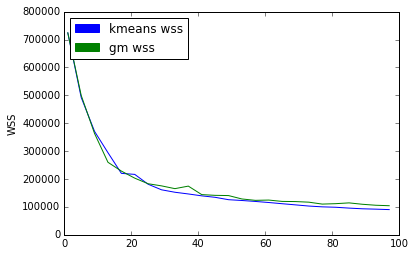

In [30]:
plt.plot(cluster_size, kmeans_wss_vals, 'b', cluster_size, gmm_wss_vals, 'g')
blue_patch = mpatches.Patch(color='blue', label='kmeans wss')
green_patch = mpatches.Patch(color='green', label='gm wss')

plt.legend(handles=[blue_patch, green_patch], loc='upper left')

plt.ylabel("WSS")
plt.show()

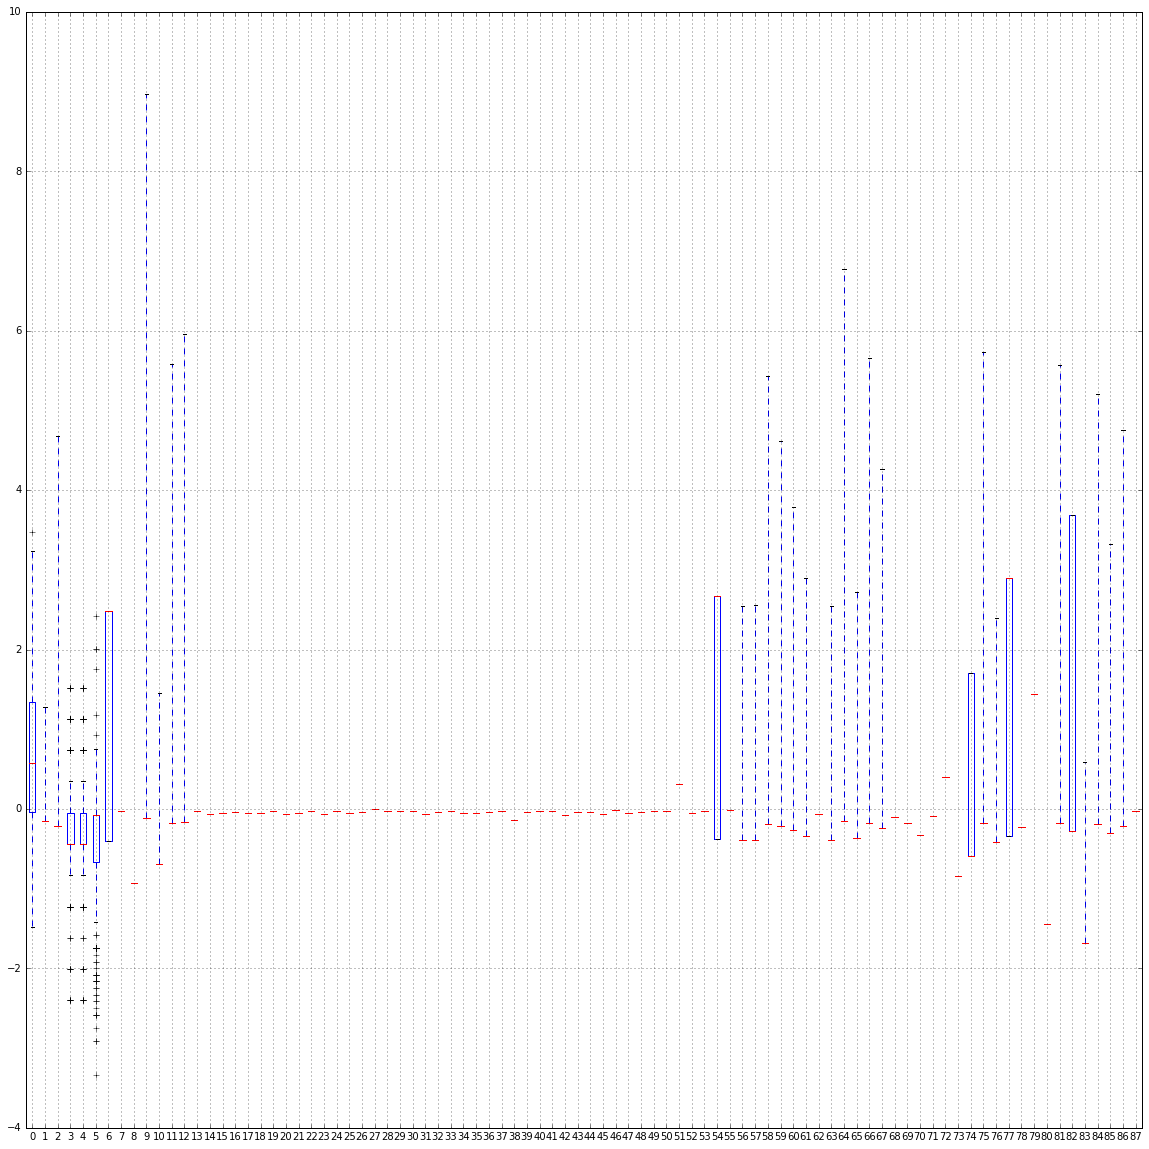

In [31]:
# Part 2 salient attribute
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

cluster_size = 40
gmm = mixture.GMM(n_components=cluster_size, random_state=20160217)

gmm_predict = gmm.fit_predict(census_data_scaled_transformed)

cluster_instances = []
# Iterate over each instance of the dataset
for i in range(0, len(gmm_predict)):
    # If that dataset instance is in the right cluster
    if (gmm_predict_pca[i] == 5):
        cluster_instances.append(i)

transformed_cluster = census_data_scaled.iloc[census_data_scaled_transformed]
normal_cluster = census_data_scaled.iloc[cluster_instances]

plt.figure(figsize=(20,20))
               
normal_cluster.boxplot(return_type='axes')

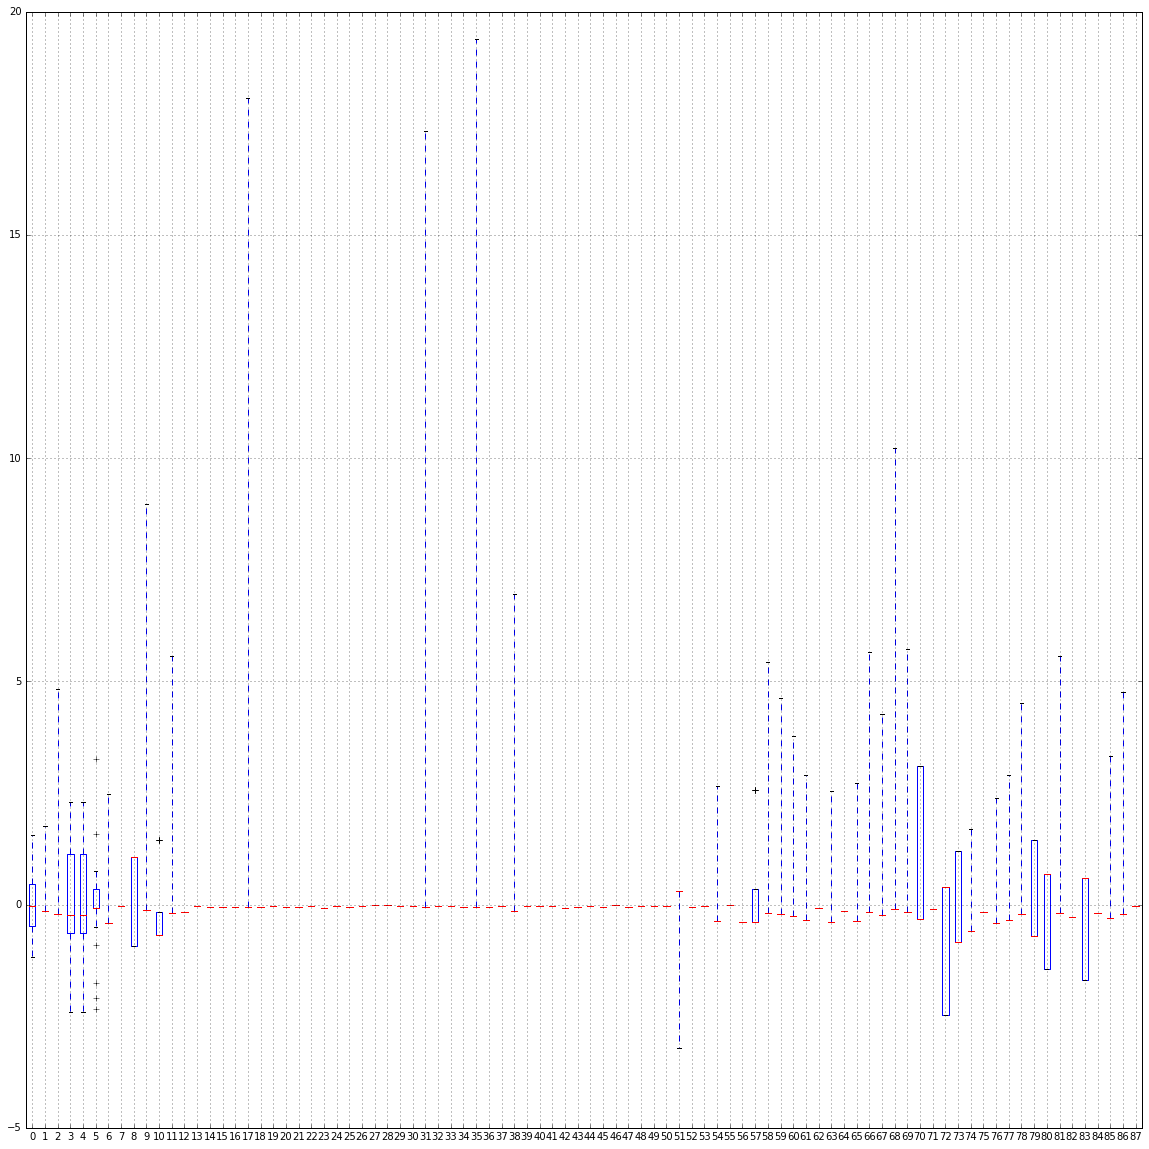

In [32]:
plt.figure(figsize=(20,20))
transformed_cluster.boxplot(return_type='axes')